In [1]:
import awkward as ak
import numba
import numpy as np
import pandas as pd
import awkward as ak
import vector
vector.register_numba()
vector.register_awkward()
import os

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import mplhep as hep
hep.style.use(hep.style.ROOT)

from importlib import reload

import numba
import spanet_predictions
# New assignment from Matej
from spanet_assignments import assign_prov_higgs_first

In [20]:
pwd

'/work/dvalsecc/ttHbb/ttHbb_jets_partons_studies/SPANET'

In [3]:
@numba.njit
def assign_provenance_and_prob(t1pred, t2pred, hpred, 
                      t1prob, t2prob, hprob, njets):
    out = np.zeros((t1pred.shape[0], njets)) -1
    prob = np.zeros((t1pred.shape[0], njets, 3), dtype=np.float32)-np.float32(np.inf)
    
    #print(prob)
    for iev, (t1, t2, h, t1p, t2p, hp) in enumerate(zip(t1pred, t2pred, hpred, t1prob, t2prob, hprob)):
    
        if t1[0] == -2:
            prob_t1 = -np.inf
        else:
            prob_t1 = t1p[t1[0]][t1[1]][t1[2]]
            
        if t2[0] == -2:
            prob_t2 = -np.inf
        else:
            prob_t2 = t2p[t2[0]]
            
        if h[0] == -2:
            prob_h = -np.inf
        else:
            prob_h = hp[h[0]][h[1]]
            
        
        # prob_t1 = t1p[t1[0]][t1[1]][t1[2]]
        # prob_t2 = t2p[t2[0]][t2[1]]
        # prob_h = hp[h[0]][h[1]]
        # print(prob_t1, prob_t2, prob_h)
        
        for i in t1: 
            out[iev][i] = 1
            prob[iev][i][0] = prob_t1
        for i in t2: 
            out[iev][i] = 2
            prob[iev][i][1] = prob_t2
        for i in h: 
            out[iev][i] = 3
            prob[iev][i][2] = prob_h

    return out, prob

In [49]:
@numba.njit
def get_assignment_indices(prov, njets):
    h_idx = np.ones((prov.shape[0], 2), dtype=np.int8)*-1
    thad_w_idx = np.ones((prov.shape[0], 2), dtype=np.int8)*-1
    thad_b_idx = np.ones((prov.shape[0], 1), dtype=np.int8)*-1
    tlep_idx = np.ones((prov.shape[0], 1), dtype=np.int8)*-1
    
    for ev, jets in enumerate(prov):
        #indicies for higgs and thad filling 
        nh, nthad = 0,0
        for i, p in enumerate(jets):
            if p == 1:
                h_idx[ev, nh] = i
                nh +=1
            elif p == 2:
                thad_b_idx[ev,0] = i
            elif p== 3:
                tlep_idx[ev, 0] = i
            elif p== 5:
                thad_w_idx[ev, nthad] = i
                nthad+=1
    return  h_idx,thad_w_idx,thad_b_idx,tlep_idx

# Use the onnx export

In [4]:
basedir= "/work/dvalsecc/ttHbb/ttHbb_jets_partons_studies/sig_bkg_30_08_2023_v2/out_forTraining_sig_bkg"
#basedir= "/eos/user/d/dvalsecc/www/ttHbbAnalysis/training_dataset/v3_sig_forTrainingDataset/"

In [5]:
os.listdir(basedir)

['all_jets_fullRun2_ttHTobb_forTraining_2018_v3.parquet',
 'all_jets_fullRun2_ttHTobb_forTraining_2016_PreVFP_v3.parquet',
 'all_jets_fullRun2_ttHTobb_forTraining_2017_v3.parquet',
 'all_jets_fullRun2_ttHTobb_forTraining_2016_PostVFP_v3.parquet']

In [6]:
df = ak.from_parquet(basedir)

In [7]:
df.fields

['jets',
 'partons_matched',
 'partons',
 'generator_info',
 'lepton_partons',
 'lepton_reco',
 'met',
 'higgs',
 'weight']

In [8]:
(jets,_,_,_,_,lep, met,_, weight) = ak.unzip(df)
jets = ak.with_name(jets, name="Momentum4D")
lep = ak.with_name(lep, name="Momentum4D")
met = ak.with_name(met, name="Momentum4D")

In [9]:
jets

<MomentumArray4D [[{pt: 108, eta: 0.826, ... prov: -1}]] type='3584250 * var * M...'>

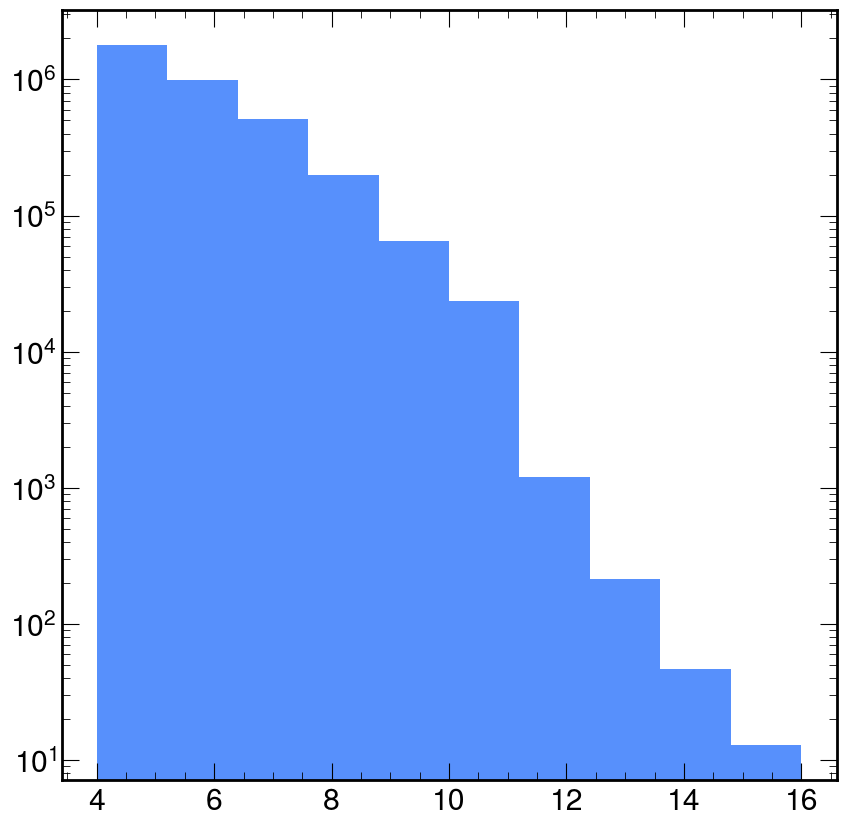

In [10]:
plt.hist(ak.num(jets))
plt.yscale("log")

In [11]:
import onnxruntime    # to inference ONNX models, we use the ONNX Runtime
sess_options = onnxruntime.SessionOptions()

sess_options.intra_op_num_threads = 10
sess_options.inter_op_num_threads = 4
#sess_options.intra_op_num_threads = 15
sess_options.execution_mode = onnxruntime.ExecutionMode.ORT_PARALLEL
sess_options.graph_optimization_level = onnxruntime.GraphOptimizationLevel.ORT_ENABLE_ALL


session = onnxruntime.InferenceSession(
    f"spanet-gpu3.onnx", 
    sess_options = sess_options,
    providers=['CUDAExecutionProvider'], #'CPUExecutionProvider']
)

for input in session.get_inputs():
    print(f"{input.name}, {input.shape}")
    
for output in session.get_outputs():
    print(f"{output.name}, {output.shape}")

Source_data, ['batch_size', 'num_Source', 4]
Source_mask, ['batch_size', 'num_Source']
Met_data, ['batch_size', 'num_Met', 3]
Met_mask, ['batch_size', 'num_Met']
Lepton_data, ['batch_size', 'num_Lepton', 3]
Lepton_mask, ['batch_size', 'num_Lepton']
ht_data, ['batch_size', 'num_ht', 1]
ht_mask, ['batch_size', 'num_ht']
t1_assignment_log_probability, ['Reshapet1_assignment_log_probability_dim_0', 'Reshapet1_assignment_log_probability_dim_1', 'Reshapet1_assignment_log_probability_dim_2', 'Reshapet1_assignment_log_probability_dim_3']
t2_assignment_log_probability, ['Reshapet2_assignment_log_probability_dim_0', 'Reshapet2_assignment_log_probability_dim_1']
h_assignment_log_probability, ['Reshapeh_assignment_log_probability_dim_0', 'Reshapeh_assignment_log_probability_dim_1', 'Reshapeh_assignment_log_probability_dim_2']
t1_detection_log_probability, ['Logt1_detection_log_probability_dim_0']
t2_detection_log_probability, ['Logt1_detection_log_probability_dim_0']
h_detection_log_probability, [

2025-05-06 11:26:12.558135970 [E:onnxruntime:Default, provider_bridge_ort.cc:1480 TryGetProviderInfo_CUDA] /onnxruntime_src/onnxruntime/core/session/provider_bridge_ort.cc:1193 onnxruntime::Provider& onnxruntime::ProviderLibrary::Get() [ONNXRuntimeError] : 1 : FAIL : Failed to load library libonnxruntime_providers_cuda.so with error: libcublasLt.so.11: cannot open shared object file: No such file or directory

2025-05-06 11:26:12.558178283 [W:onnxruntime:Default, onnxruntime_pybind_state.cc:747 CreateExecutionProviderInstance] Failed to create CUDAExecutionProvider. Please reference https://onnxruntime.ai/docs/execution-providers/CUDA-ExecutionProvider.html#requirements to ensure all dependencies are met.


In [12]:
jets_padded = ak.fill_none(ak.pad_none(jets, 16, clip=True), {"btag":0., "pt":0., "phi":0., "eta":0.})

data = np.transpose(
    np.stack([
    ak.to_numpy(jets_padded.btag),
    ak.to_numpy(jets_padded.eta),
    ak.to_numpy(jets_padded.phi),
    #ak.to_numpy(jets_padded.pt),
    np.log(1 + ak.to_numpy(jets_padded.pt))
    
    ]),
    axes=[1,2,0]).astype(np.float32)

mask = ~ak.to_numpy(jets_padded.pt == 0)

met_data = np.stack([ak.to_numpy(met.eta),
                     ak.to_numpy(met.phi),
                     #ak.to_numpy(met.pt)
                     np.log(1+ ak.to_numpy(met.pt))
                    ], axis=1)[:,None,:].astype(np.float32)

lep_data = np.stack([ak.to_numpy(lep[:,0].eta),
                     ak.to_numpy(lep[:,0].phi),
                     #ak.to_numpy(lep[:,0].pt)
                     np.log(1+ ak.to_numpy(lep[:,0].pt))
                ], axis=1)[:,None,:].astype(np.float32)

ht_array = np.sum(ak.to_numpy(jets_padded.pt), axis=1)[:,None, None].astype(np.float32)

mask_global = np.ones(shape=[met_data.shape[0], 1]) == 1

njets_good = ak.sum(mask, axis=1)

In [13]:
batch_size = 512
nbatches = data.shape[0]// batch_size
print(f"{nbatches=}")

nbatches=7000


In [52]:
from rich.progress import track

provenance = np.zeros((data.shape[0], 16))
provenance_no_overlap = np.zeros((data.shape[0], 16))

prob_assignment = np.zeros((data.shape[0], 16, 3), dtype=np.int8)
predictions_index = [ np.zeros((data.shape[0], 3), dtype=np.int8),
                     np.zeros((data.shape[0], 1), dtype=np.int8),
                     np.zeros((data.shape[0], 2), dtype=np.int8)
                    ]
predictions_index_nooverlap = [ 
                     np.zeros((data.shape[0], 2), dtype=np.int8), #thad W
                     np.zeros((data.shape[0], 1), dtype=np.int8), #thad b
                     np.zeros((data.shape[0], 1), dtype=np.int8), #tlep
                     np.zeros((data.shape[0], 2), dtype=np.int8)  #higgs
                    ]

for i in track(range(nbatches), "Inference"):
    start = i*batch_size
    if i < (nbatches-1):
        stop = start+batch_size
    else:
        stop = len(data)
    outputs = session.run(input_feed={
        "Source_data": data[start:stop],
        "Source_mask": mask[start:stop],
        "Met_data": met_data[start:stop],
        "Met_mask": mask_global[start:stop],
        "Lepton_data": lep_data[start:stop],
        "Lepton_mask": mask_global[start:stop],
        "ht_data": ht_array[start:stop], 
        "ht_mask": mask_global[start:stop]},
        output_names=["t1_assignment_log_probability", "t2_assignment_log_probability",
                     "h_assignment_log_probability"]
        )

    preds_nomask = spanet_predictions.extract_predictions(outputs[0:3], masking=False)
    prov, prob = assign_provenance_and_prob(*preds_nomask, outputs[0], outputs[1], outputs[2], 16)
    #print(prob)
    provenance[start:stop] = prov
    prob_assignment[start:stop]= prob
    for j in range(3):
       predictions_index[j][start:stop] = preds_nomask[j]
    
    prov_no_over, assign_order_counts = assign_prov_higgs_first(outputs)
    provenance_no_overlap[start:stop] = prov_no_over


    (h_idx_nooverlap, thad_w_idx_nooverlap,
     thad_b_idx_nooverlap, tlep_idx_nooverlap) = get_assignment_indices(prov_no_over, 16)
    predictions_index_nooverlap[0][start:stop] = thad_w_idx_nooverlap
    predictions_index_nooverlap[1][start:stop] = thad_b_idx_nooverlap
    predictions_index_nooverlap[2][start:stop] = tlep_idx_nooverlap
    predictions_index_nooverlap[3][start:stop] = h_idx_nooverlap
            
    break

Output()

In [74]:
probabilities = np.exp(ak.to_numpy(prob_assignment))
# Factor two for symmetry reasons
probabilities[:,:,0] = probabilities[:,:,0] *2
probabilities[:,:,2] = probabilities[:,:,2] * 2

njets_good = ak.sum(mask, axis=1)
prob_assign_reshape = np.reshape(prob_assignment, (-1, 3) )
prob_masked = prob_assign_reshape[mask.flatten()]
prob_ak = ak.unflatten(ak.from_numpy(prob_masked), njets_good)

prov_overlap_ak = ak.unflatten(ak.from_numpy(provenance_no_overlap)[mask], njets_good)

In [90]:
df["prob_ak"] = prob_ak
df["jets"] = ak.zip( dict(zip(df.jets.fields,ak.unzip(df.jets))) |  {"prov_Thad": prob_ak[:,:,0],
                                                                     "prov_Tlep": prob_ak[:,:,1],
                                                                     "prov_H": prob_ak[:,:,2],
                                                                    })
df["jets"] = ak.with_field(df.jets, prov_overlap_ak, "prov_nooverlap")
df["higgs_predicted_indices"] = ak.from_numpy(predictions_index[2])
df["tophad_predicted_indices"] = ak.from_numpy(predictions_index[0])
df["toplep_predicted_indices"] = ak.from_numpy(predictions_index[1])

df["higgs_predicted_indices_nooverlap"] = ak.from_numpy(predictions_index_nooverlap[3])
df["tophad_w_predicted_indices_nooverlap"] = ak.from_numpy(predictions_index_nooverlap[0])
df["tophad_b_predicted_indices_nooverlap"] = ak.from_numpy(predictions_index_nooverlap[1])
df["toplep_predicted_indices_nooverlap"] = ak.from_numpy(predictions_index_nooverlap[2])



In [91]:
ak.to_parquet(df, basedir + "/all_jets_fullRun2_ttHbb_forTraining_allyears_spanetprov_nooverlap_v3.parquet")